In [1]:
using Yao, BitBasis, StatsBase, LinearAlgebra, SparseArrays, Plots

Starting from an idea proposed by [@Ket.G](https://www.youtube.com/channel/UCedVPGH5fnWBmsR4oHVOX6w): 

>  ...tratar el hundir la flota. Imaginemos un tablero 4x4 y en el un barco 2x1. [snip] La idea de que sea cuántico es que puedes preguntar por dos casillas al mismo tiempo(o las que sean). Si las dos están vacías dirá siempre agua, si las dos son el barco, dirá tocado pero claro, si es una de cada podría colapsar hacia cualquiera de las dos opciones

*(... try to sink the fleet. Imagine a grid, 4x4 and a ship 2x1. The idea is a quantum version where you can ask for two positions at the same time (or however many). If the two are empty it will always say "water", if both are the ship, it will say "hit" but, of course, if it is one of each it can collapse to either of the two options.*

Let's have a go. First we need the function which will give the desired results. Assuming we have an $n \times n$ grid we can [flatten](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) the grid to a vector and represent each location with a qubit (that will be $n^2$ qubits, clearly we can't have a ver big board!).

To make the query we can prepare a state with $n^2$ qubits placing a $NOT$ gate at each of the positions we want to query. We'll also need an ancillary bit to store the result, applying two quarter turns, conditional on the occupied qubits. This way the ancillary bit will contain $|0\rangle$, if no queried position matches, a 50/50 superposition if only one matches and a $|0\rangle$ if both match. 

<img src="battleships-query-circuit.png" alt="Battleships query circuit" style="height: 250px;"/>

In this example the battleship is at locations 1 and 2 and the query is for locations 2 and 3. The result in the last qubit is 50/50 as expected. You can play with the circuit (for example [in Quirk](https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B1%2C%22X%22%2C%22X%22%5D%2C%5B1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B%22Chance%22%2C%22Chance%22%2C%22Chance%22%2C%22Chance%22%2C%22Chance%22%5D%5D%2C%22gates%22%3A%5B%7B%22id%22%3A%22~4kdg%22%2C%22name%22%3A%22Uf%22%2C%22circuit%22%3A%7B%22cols%22%3A%5B%5B1%2C%22%E2%80%A2%22%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C%22X%5E%C2%BD%22%5D%5D%7D%7D%5D%7D)) and check that it gives the expected results for other combinations. We'll assume that we don't know the actual positions, taking this circuit as a black box, or [oracle](https://docs.microsoft.com/en-us/quantum/concepts/oracles), called $U_f$.

In [2]:
# Parameters for the board
n=2
bits = n^2 + 1
ship_locs = [2, 3]

# Define the query circuit
sqrt(gate::AbstractBlock) = matblock(√mat(X))
oracle = chain(bits, control(i, bits=>sqrt(X)) for i in ship_locs)
query(p1,p2) = zero_state(bits) |> chain(bits, put(p1=>X), put(p2=>X))

# Check the results
query(3,4) |> oracle |> s -> measure(s, nshots=10)

10-element Array{BitStr{5,Int64},1}:
 11100 ₍₂₎
 11100 ₍₂₎
 01100 ₍₂₎
 01100 ₍₂₎
 01100 ₍₂₎
 01100 ₍₂₎
 01100 ₍₂₎
 11100 ₍₂₎
 01100 ₍₂₎
 11100 ₍₂₎

We can see that bits 3 and 4 (reading from right to left) are set and the most significant bit is either 0 or 1, as expected. 

Now, given that the task is to identify which of the squares is occupied, we could just query all the squares on the board using a binary tree search or something. But we can apply some interesting quantum ideas here.... Assuming we can manipulate the state before and after the query, instead of querying the squares individually we'll put all the qubits into superposition and [query them together](https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%5D%2C%5B%22X%22%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C%22X%22%2C1%2C1%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C%22X%22%2C1%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C%22X%22%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C1%2C%22X%22%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%5D%2C%5B%22Chance%22%2C%22Chance%22%2C%22Chance%22%2C%22Chance%22%2C%22Chance%22%2C%22Chance%22%5D%5D%2C%22gates%22%3A%5B%7B%22id%22%3A%22~4kdg%22%2C%22name%22%3A%22Uf%22%2C%22circuit%22%3A%7B%22cols%22%3A%5B%5B1%2C%22%E2%80%A2%22%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C%22X%5E%C2%BD%22%5D%5D%7D%7D%5D%7D)? For the 2x2 case it might look something like this: <img src="battleships-quantum-circuit.png" alt="Battleships quantum circuit" style="height: 250px;"/>

There is a non-zero chance of reading a $|1\rangle$ from both the locations of the ship and a 0% chance from other locations. This means that simply reading the result a "few" times will give us our answer. In fact *just enough* readings to tell us the two positions of the ship.

In [3]:
gen = repeat(H, 1:bits-1)
controls = [control(bits, i=>X) for i in 1:bits-1]
circuit = chain(bits, gen, controls..., oracle, gen)

nqubits: 5
chain
├─ repeat on (1, 2, 3, 4)
│  └─ H
├─ control(5)
│  └─ (1,) X
├─ control(5)
│  └─ (2,) X
├─ control(5)
│  └─ (3,) X
├─ control(5)
│  └─ (4,) X
├─ chain
│  ├─ control(2)
│  │  └─ (5,) matblock(...)
│  └─ control(3)
│     └─ (5,) matblock(...)
└─ repeat on (1, 2, 3, 4)
   └─ H


In [4]:
function find_position()
    bits_set = Int[]
    q = 0
    while length(bits_set) < 2
        result = zero_state(bits) |> circuit |> focus!(1:bits-1) |> measure
        bits_set = union(bits_set, baddrs(result[1]))
        q += 1
    end
    @assert sort(bits_set) == ship_locs
    (ship_at=bits_set, queries=q)
end
find_position()

(ship_at = [2, 3], queries = 2)

So how many queries do we have to do on average? You could be lucky and get the result in 1 or unlucky and need more. 

The exact probabilities could be calculated but the point is that it **doesn't depend on the size of the grid**, only the number of locations we're interested in, in other words the size of the ship, in this case 2. It would be the same for a $3 \times 3$ or $100 \times 100$. In  terms of complexity it's O(1). Running the experiment empirically the average number of queries is just over 5 (*remember this is for any $n$!*) and follows some sort of exponential distribution.

5.198

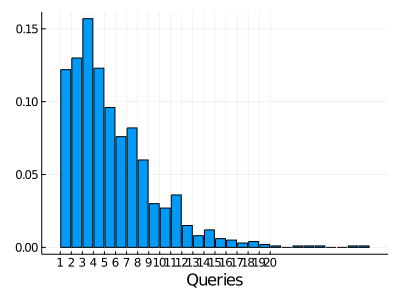

In [5]:
results = [find_position().queries for i in 1:1000]
print(mean(results))
histogram(results, size=(400,300), normed=true, xticks=(1:20), bar_width=0.9, legend=false, xlabel="Queries")

According to Quirk the chance of a |0000> result is over 60%. These results give us no information and waste cycles so I wondered if there was a better combination of gates. The intuition is to rotate the search vector away from |0000> to reduce its probability of occuring. After some trial and error it turns out there is in fact what seems to be a [better circuit](https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%5D%2C%5B%22X%22%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C%22X%22%2C1%2C1%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C%22X%22%2C1%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C%22X%22%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C1%2C%22X%22%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22Y%5E%C2%BD%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22Z%22%5D%2C%5B%22%E2%80%A2%22%2C1%2C1%2C1%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%5D%2C%5B%22Chance5%22%5D%5D%2C%22gates%22%3A%5B%7B%22id%22%3A%22~4kdg%22%2C%22name%22%3A%22Uf%22%2C%22circuit%22%3A%7B%22cols%22%3A%5B%5B1%2C%22%E2%80%A2%22%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C%22X%5E%C2%BD%22%5D%5D%7D%7D%5D%7D) which includes two additional twists on the ancillary qubit and a second instance of the oracle. 

<img src="battleships-quantum-circuit-improved.png" alt="Battleships quantum circuit" style="height: 250px;"/>

This should give us the answer in a much fewer runs. 

If we also allow ourselves to use the oracle twice we can get the answer in a [single query](https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%5D%2C%5B%22X%22%2C1%2C1%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C%22X%22%2C1%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C%22X%22%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C%22X%22%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C1%2C%22Y%5E%C2%BD%22%5D%2C%5B1%2C1%2C1%2C1%2C%22Z%22%5D%2C%5B%22~d596%22%5D%2C%5B%22~d596%22%5D%2C%5B1%2C1%2C1%2C1%2C%22Y%5E%C2%BD%22%5D%2C%5B%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%5D%2C%5B%22Chance%22%2C%22Chance%22%2C%22Chance%22%2C%22Chance%22%2C%22Chance%22%5D%2C%5B%22Chance5%22%5D%5D%2C%22gates%22%3A%5B%7B%22id%22%3A%22~4kdg%22%2C%22name%22%3A%22Uf%22%2C%22circuit%22%3A%7B%22cols%22%3A%5B%5B1%2C%22%E2%80%A2%22%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C%22X%5E%C2%BD%22%5D%5D%7D%7D%2C%7B%22id%22%3A%22~dlc%22%2C%22name%22%3A%22Uf%22%2C%22circuit%22%3A%7B%22cols%22%3A%5B%5B1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C%22X%5E%C2%BD%22%5D%5D%7D%7D%2C%7B%22id%22%3A%22~d596%22%2C%22name%22%3A%22Uf%22%2C%22circuit%22%3A%7B%22cols%22%3A%5B%5B1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%5E%C2%BD%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C1%2C%22X%5E%C2%BD%22%5D%5D%7D%7D%5D%7D)! 


<img src="battleships-quantum-circuit-improved2.png" alt="Battleships quantum circuit" style="height: 250px;"/>

According to Quirk there is a 100% change of getting the answer immediatelly. Unfortunately, I haven't been able to reproduce that in Yao. Not sure if this is a bug in me, in Quirk or in Yao. I'd need to work out the maths by hand.

In [6]:
extray = chain(bits, put(bits=>sqrt(Y)))
extraz = chain(bits, put(bits=>Z))
circuit = chain(bits, gen, controls..., extray, extraz, oracle, oracle, extray, gen)

nqubits: 5
chain
├─ repeat on (1, 2, 3, 4)
│  └─ H
├─ control(5)
│  └─ (1,) X
├─ control(5)
│  └─ (2,) X
├─ control(5)
│  └─ (3,) X
├─ control(5)
│  └─ (4,) X
├─ chain
│  └─ put on (5)
│     └─ matblock(...)
├─ chain
│  └─ put on (5)
│     └─ Z
├─ chain
│  ├─ control(2)
│  │  └─ (5,) matblock(...)
│  └─ control(3)
│     └─ (5,) matblock(...)
├─ chain
│  ├─ control(2)
│  │  └─ (5,) matblock(...)
│  └─ control(3)
│     └─ (5,) matblock(...)
├─ chain
│  └─ put on (5)
│     └─ matblock(...)
└─ repeat on (1, 2, 3, 4)
   └─ H


In [7]:
zero_state(bits) |> circuit |> s->measure(s,nshots=10)

10-element Array{BitStr{5,Int64},1}:
 00110 ₍₂₎
 00110 ₍₂₎
 10110 ₍₂₎
 00110 ₍₂₎
 00000 ₍₂₎
 10110 ₍₂₎
 10000 ₍₂₎
 00110 ₍₂₎
 00110 ₍₂₎
 10110 ₍₂₎

2.03

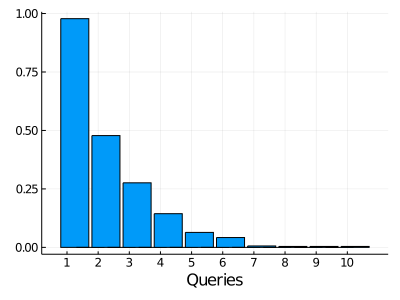

In [8]:
function find_position()
    bits_set = Int[]
    q = 0
    while length(bits_set) < 2
        result = zero_state(bits) |> circuit |> focus!(1:bits-1) |> measure
        bits_set = union(bits_set, baddrs(result[1]))
        q += 1
    end
    @assert sort(bits_set) == [2,3]
    (ship_at=bits_set, queries=q)
end
results = [find_position().queries for i in 1:1000]
print(mean(results))
histogram(results, size=(400,300), normed=true, xticks=(1:10), bar_width=0.9, legend=false, xlabel="Queries")

That's still pretty good.